## Importando bibliotecas

In [1]:
import os
import sys

import warnings                                  # `do not disturb` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt
import seaborn as sns                            # more plots
sns.set_style("darkgrid")

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy as sp
from scipy.fft import fft, fftfreq, rfft, irfft, fftshift

from datetime import datetime, timedelta
import holidays
import calendar

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("paper")

params = {'figure.figsize': [14, 14], 
          'axes.labelsize': 16,
          'axes.titlesize':18, 
          'font.size': 16,
          'legend.fontsize': 12, 
          'xtick.labelsize': 12, 
          'ytick.labelsize': 12
         }

plt.rcParams.update(params)


In [3]:
# Seta display de x linhas
pd.set_option('display.max_row', 100)
# Seta display de x colunas
pd.set_option('display.max_columns', 15)

## Importando os datasets

In [4]:
%%time
# Definindo os nomes das colunas
typing = {'instalacao': 'str'}

#importando o arquivo - Dataset de dados de carga Residenciais
data_res = pd.read_csv(r'C:/Users/vitmi/Desktop/TCC/Data/load_data/Data_res_mean.csv', encoding='utf-8', 
                       sep = ';', decimal = '.',  dtype = typing, parse_dates = ['data_medicao'])

#importando o arquivo - Dataset de dados de carga Industriais
data_ind = pd.read_csv(r'C:/Users/vitmi/Desktop/TCC/Data/load_data/data_ind_mean.csv', encoding='utf-8', 
                       sep = ';', decimal = '.',  dtype = typing, parse_dates = ['data_medicao'])

#importando o arquivo - Dataset de dados de carga Comerciais
data_com = pd.read_csv(r'C:/Users/vitmi/Desktop/TCC/Data/load_data/data_com_mean.csv', encoding='utf-8', 
                       sep = ';', decimal = '.',  dtype = typing, parse_dates = ['data_medicao'])

#importando o arquivo - Dataset de dados de carga - Poder Público Municipal
data_ppm = pd.read_csv(r'C:/Users/vitmi/Desktop/TCC/Data/load_data/Data_ppm_mean.csv', encoding='utf-8', 
                       sep = ';', decimal = '.',  dtype = typing, parse_dates = ['data_medicao'])

#importando o arquivo - Dataset de dados de carga - Serviço Público - Água, Saneamento e Esgoto
data_sp = pd.read_csv(r'C:/Users/vitmi/Desktop/TCC/Data/load_data/Data_sp_mean.csv', encoding='utf-8', 
                       sep = ';', decimal = '.',  dtype = typing, parse_dates = ['data_medicao'])

Wall time: 2.19 s


### Extraindo dados de Tempo

In [5]:
def extract_time(df):
    df['time'] = df['data_medicao'].dt.time

def extract_week(df):
    df['n_semana'] = df['data_medicao'].apply(lambda x: x.strftime("%V"))
    df[['n_semana']] = df[['n_semana']].astype("int")


In [6]:
def label_weekday(df):
    if df['week_day'] == 'MONDAY' :
        return 1
    if df['week_day'] == 'TUESDAY' :
        return 2
    if df['week_day'] == 'WEDNESDAY' :
        return 3
    if df['week_day'] == 'THURSDAY' :
        return 4
    if df['week_day'] == 'FRIDAY' :
        return 5
    if df['week_day'] == 'SATURDAY' :
        return 6
    if df['week_day'] == 'SUNDAY' :
        return 7
   

In [7]:
def num_weekday(df):
    df['num_weekday'] = df.apply (lambda row: label_weekday(row), axis=1)

In [8]:
nomes = [data_res, data_ind, data_com, data_ppm, data_sp]

In [9]:
%%time
for i in nomes:
    extract_time(i)
    extract_week(i)
    num_weekday(i)

Wall time: 1min 1s


## Estudo 1 - Carga durante o ano

In [10]:
def filteryear(df):
    data_2018 = df[(df['year']) == 2018]
    data_2018_grouped = pd.DataFrame(data_2018.groupby(data_2018['data_medicao'])\
                                     ['valor_kwh'].mean()).reset_index(drop = False)
    data_2018_grouped = data_2018_grouped.reset_index()

    data_2019 = df[(df['year']) == 2019]
    data_2019_grouped = pd.DataFrame(data_2019.groupby(data_2019['data_medicao'])\
                                     ['valor_kwh'].mean()).reset_index(drop = False)
    data_2019_grouped = data_2019_grouped.reset_index()
    
    return data_2018_grouped, data_2019_grouped


In [11]:
res_tot_2018, res_tot_2019 = filteryear(data_res)
ind_tot_2018, ind_tot_2019 = filteryear(data_ind)
com_tot_2018, com_tot_2019 = filteryear(data_com)
ppm_tot_2018, ppm_tot_2019 = filteryear(data_ppm)
sp_tot_2018, sp_tot_2019 = filteryear(data_sp)

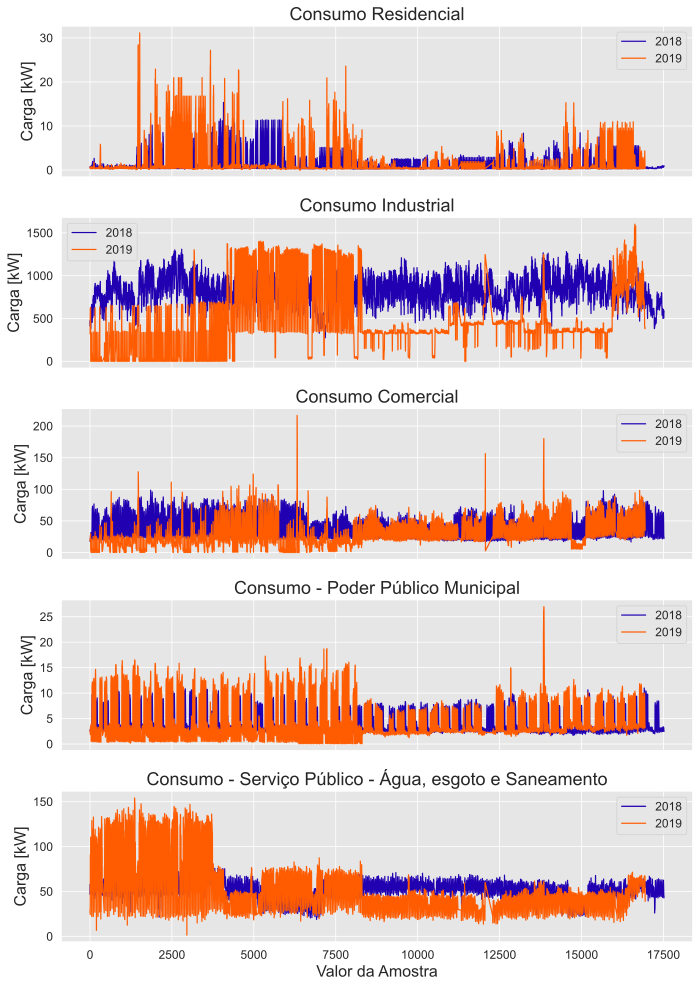

In [27]:
fig, axs = plt.subplots(nrows = 5, ncols=1, sharex=True)
sns.lineplot(data = res_tot_2018, x="index", y="valor_kwh", ax=axs[0], label = '2018', color = 'xkcd:ultramarine')
sns.lineplot(data = res_tot_2019, x="index", y="valor_kwh", ax=axs[0], label = '2019', color = 'xkcd:bright orange')
axs[0].set_ylabel("Carga [kW]")
axs[0].set_title('Consumo Residencial')

sns.lineplot(data = ind_tot_2018, x="index", y="valor_kwh", ax=axs[1], label = '2018', color = 'xkcd:ultramarine')
sns.lineplot(data = ind_tot_2019, x="index", y="valor_kwh", ax=axs[1], label = '2019', color = 'xkcd:bright orange')
axs[1].set_ylabel("Carga [kW]")
axs[1].set_title('Consumo Industrial')

sns.lineplot(data = com_tot_2018, x="index", y="valor_kwh", ax=axs[2], label = '2018', color = 'xkcd:ultramarine')
sns.lineplot(data = com_tot_2019, x="index", y="valor_kwh", ax=axs[2], label = '2019', color = 'xkcd:bright orange')
axs[2].set_ylabel("Carga [kW]")
axs[2].set_title('Consumo Comercial')

sns.lineplot(data = ppm_tot_2018, x="index", y="valor_kwh", ax=axs[3], label = '2018', color = 'xkcd:ultramarine')
sns.lineplot(data = ppm_tot_2019, x="index", y="valor_kwh", ax=axs[3], label = '2019', color = 'xkcd:bright orange')
axs[3].set_ylabel("Carga [kW]")
axs[3].set_title('Consumo - Poder Público Municipal')

sns.lineplot(data = sp_tot_2018, x="index", y="valor_kwh", ax=axs[4], label = '2018', color = 'xkcd:ultramarine')
sns.lineplot(data = sp_tot_2019, x="index", y="valor_kwh", ax=axs[4], label = '2019', color = 'xkcd:bright orange')
axs[4].set_xlabel("Valor da Amostra")
axs[4].set_ylabel("Carga [kW]")
axs[4].set_title('Consumo - Serviço Público - Água, esgoto e Saneamento')

fig.tight_layout()
plt.savefig('C:/Users/vitmi/Desktop/TCC/Imagens/consumo_Anual.png')
plt.show()


## Estudo 2 - Carga média da semana

In [55]:
def week_mean(df):
    df_2018 = df[(df['year']) == 2018]
    df_2018_group = pd.DataFrame(df_2018.groupby(by = ['week_day', 'num_weekday', 'time'])\
                                 ['valor_kwh'].mean()).reset_index(drop = False)
    df_2018_group = df_2018_group.sort_values(by=['num_weekday', 'time'])
    
    df_2019 = df[(df['year']) == 2019]
    df_2019_group = pd.DataFrame(df_2019.groupby(by = ['week_day', 'num_weekday', 'time'])\
                                 ['valor_kwh'].mean()).reset_index(drop = False)
    df_2019_group = df_2019_group.sort_values(by=['num_weekday', 'time'])
    
    return df_2018_group, df_2019_group

In [56]:
res_2_2018, res_2_2019 = week_mean(data_res)
ind_2_2018, ind_2_2019 = week_mean(data_ind)
com_2_2018, com_2_2019 = week_mean(data_com)
ppm_2_2018, ppm_2_2019 = week_mean(data_ppm)
sp_2_2018, sp_2_2019  = week_mean(data_sp)

In [57]:
nomes_2 = [res_2_2018, res_2_2019, ind_2_2018, ind_2_2019, com_2_2018, com_2_2019,\
           ppm_2_2018, ppm_2_2019, sp_2_2018, sp_2_2019]

for i in nomes_2:
    i.reset_index(drop = True, inplace=True)
    i.reset_index(drop = False, inplace=True)

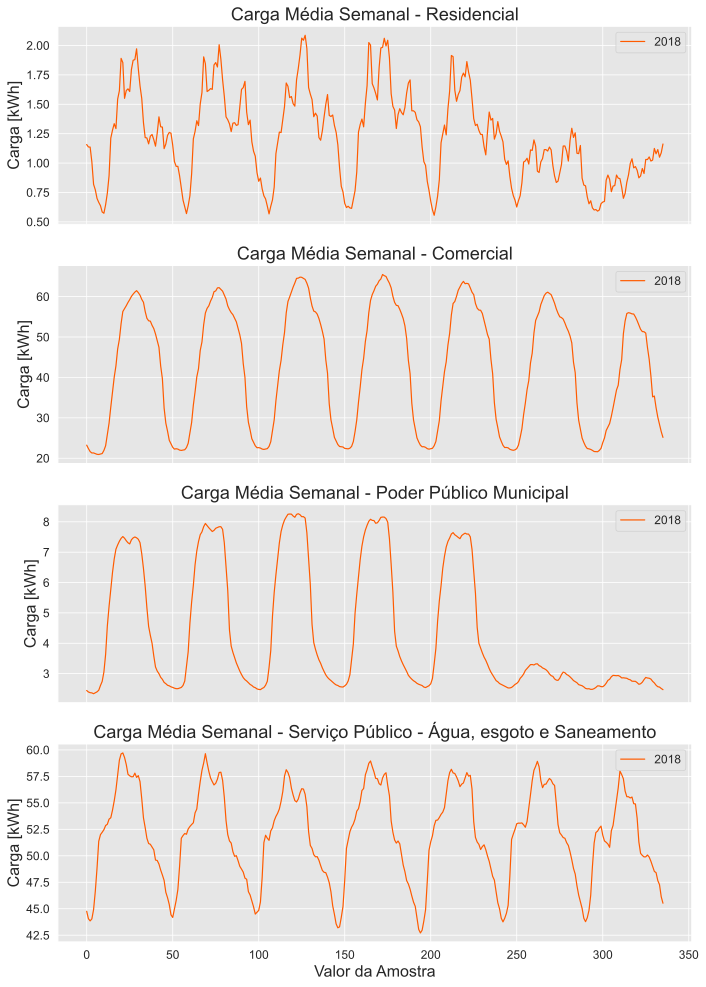

In [60]:
fig, axs = plt.subplots(nrows = 4, ncols=1, sharex=True)

sns.lineplot(data = res_2_2018, x="index", y="valor_kwh", ax=axs[0], label = '2018' , color = 'xkcd:bright orange')
axs[0].set_ylabel("Carga [kWh]")
axs[0].set_xlabel("")
axs[0].set_title('Carga Média Semanal - Residencial')

#sns.lineplot(data = ind_2_2018, x="index", y="valor_kwh", ax=axs[1], label = '2018', color = 'xkcd:gold')
#axs[1].set_ylabel("Carga [kWh]")
#axs[1].set_xlabel("")
#axs[1].set_title('Carga Média Semanal - Industrial')

sns.lineplot(data = com_2_2018, x="index", y="valor_kwh", ax=axs[1], label = '2018', color = 'xkcd:bright orange')
axs[1].set_ylabel("Carga [kWh]")
axs[1].set_xlabel("")
axs[1].set_title('Carga Média Semanal - Comercial')

sns.lineplot(data = ppm_2_2018, x="index", y="valor_kwh", ax=axs[2], label = '2018', color = 'xkcd:bright orange')
axs[2].set_ylabel("Carga [kWh]")
axs[2].set_xlabel("")
axs[2].set_title('Carga Média Semanal - Poder Público Municipal')

sns.lineplot(data = sp_2_2018, x="index", y="valor_kwh", ax=axs[3], label = '2018', color = 'xkcd:bright orange')
axs[3].set_ylabel("Carga [kWh]")
axs[3].set_xlabel("Valor da Amostra")
axs[3].set_title('Carga Média Semanal - Serviço Público - Água, esgoto e Saneamento')

fig.tight_layout()
plt.savefig('C:/Users/vitmi/Desktop/TCC/Imagens/Consumo_Semanal.png')
plt.show()

## Estudo 3 - Horário de Verao

In [37]:
def summer_time(df):
    df_2018 = df[(df['year']) == 2018]
    df_2018_group = pd.DataFrame(df_2018.groupby(by = ['week_day', 'time', 'num_weekday', 'hora_verao'])\
                                 ['valor_kwh'].mean()).reset_index(drop = False)
    
    df_2018_n = df_2018_group[(df_2018_group['hora_verao'] == 0)]
    df_2018_s = df_2018_group[(df_2018_group['hora_verao'] == 1)]
    
    df_2019 = df[(df['year']) == 2019]
    df_2019_group = pd.DataFrame(df_2019.groupby(by = ['week_day', 'time', 'num_weekday', 'hora_verao'])\
                                 ['valor_kwh'].mean()).reset_index(drop = False)
    
    df_2019_n = df_2019_group[(df_2019_group['hora_verao'] == 0)]
    df_2019_s = df_2019_group[(df_2019_group['hora_verao'] == 1)]
        
    return df_2018_n, df_2018_s, df_2019_n, df_2019_s

In [38]:
res_2018_n, res_2018_s, res_2019_n, res_2019_s = summer_time(data_res)
ind_2018_n, ind_2018_s, ind_2019_n, ind_2019_s = summer_time(data_ind)
com_2018_n, com_2018_s, com_2019_n, com_2019_s = summer_time(data_com)
ppm_2018_n, ppm_2018_s, ppm_2019_n, ppm_2019_s = summer_time(data_ppm)
sp_2018_n, sp_2018_s, sp_2019_n, sp_2019_s = summer_time(data_sp)

In [39]:
nomes_3 = [\
    res_2018_n, res_2018_s, res_2019_n, res_2019_s, ind_2018_n, ind_2018_s, ind_2019_n, ind_2019_s,\
    com_2018_n, com_2018_s, com_2019_n, com_2019_s, ppm_2018_n, ppm_2018_s, ppm_2019_n, ppm_2019_s,\
    sp_2018_n, sp_2018_s, sp_2019_n, sp_2019_s]

In [40]:
for i in nomes_3:
    i.sort_values(by=['num_weekday', 'time'], inplace=True)
    i.reset_index(drop = True, inplace=True)
    i.reset_index(drop = False, inplace=True)

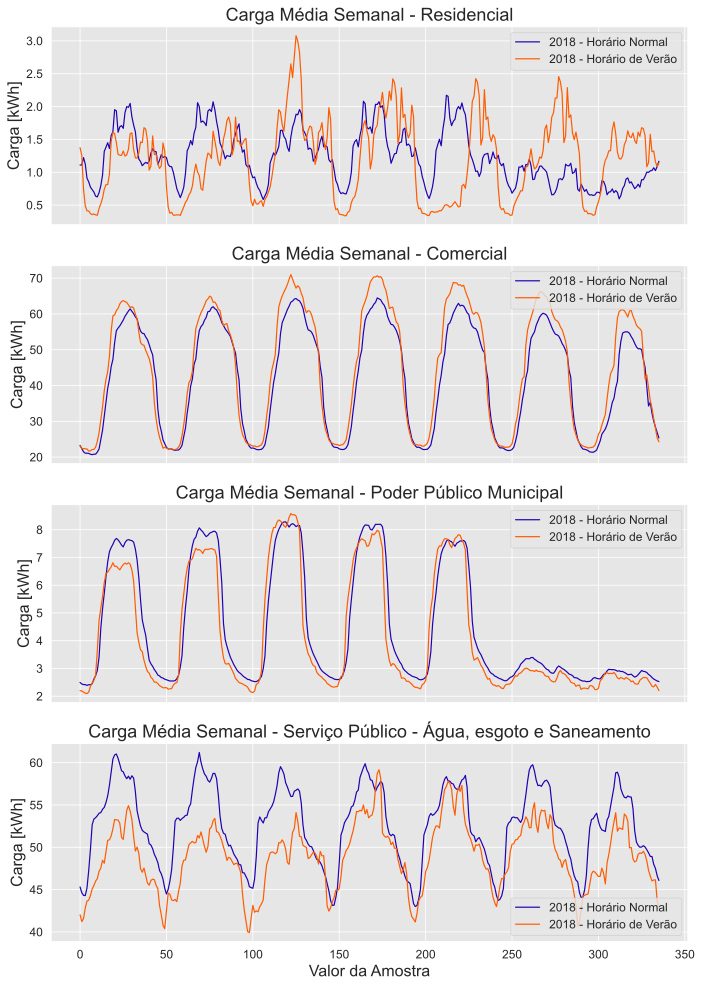

In [43]:
fig, axs = plt.subplots(nrows = 4, ncols=1,sharex=True)

sns.lineplot(data = res_2018_n, x="index", y="valor_kwh", ax=axs[0], label = '2018 - Horário Normal'  , color = 'xkcd:ultramarine')
sns.lineplot(data = res_2018_s, x="index", y="valor_kwh", ax=axs[0], label = '2018 - Horário de Verão', color = 'xkcd:bright orange')
axs[0].set_ylabel("Carga [kWh]")
axs[0].set_xlabel("")
axs[0].set_title('Carga Média Semanal - Residencial')

#sns.lineplot(data = ind_2018_n, x="index", y="valor_kwh", ax=axs[1], label = '2018 - Horário Normal'  , color = 'xkcd:ultramarine')
#sns.lineplot(data = ind_2018_s, x="index", y="valor_kwh", ax=axs[1], label = '2018 - Horário de Verão', color = 'xkcd:bright orange')
#axs[1].set_ylabel("Carga [kWh]")
#axs[1].set_xlabel("")
#axs[1].set_title('Carga Média Semanal - Industrial')

sns.lineplot(data = com_2018_n, x="index", y="valor_kwh", ax=axs[1], label = '2018 - Horário Normal'  , color = 'xkcd:ultramarine')
sns.lineplot(data = com_2018_s, x="index", y="valor_kwh", ax=axs[1], label = '2018 - Horário de Verão', color = 'xkcd:bright orange')
axs[1].set_ylabel("Carga [kWh]")
axs[1].set_xlabel("")
axs[1].set_title('Carga Média Semanal - Comercial')

sns.lineplot(data = ppm_2018_n, x="index", y="valor_kwh", ax=axs[2], label = '2018 - Horário Normal'  , color = 'xkcd:ultramarine')
sns.lineplot(data = ppm_2018_s, x="index", y="valor_kwh", ax=axs[2], label = '2018 - Horário de Verão', color = 'xkcd:bright orange')
axs[2].set_ylabel("Carga [kWh]")
axs[2].set_xlabel("")
axs[2].set_title('Carga Média Semanal - Poder Público Municipal')

sns.lineplot(data = sp_2018_n, x="index", y="valor_kwh", ax=axs[3], label = '2018 - Horário Normal'  , color = 'xkcd:ultramarine')
sns.lineplot(data = sp_2018_s, x="index", y="valor_kwh", ax=axs[3], label = '2018 - Horário de Verão', color = 'xkcd:bright orange')
axs[3].set_ylabel("Carga [kWh]")
axs[3].set_xlabel("Valor da Amostra")
axs[3].set_title('Carga Média Semanal - Serviço Público - Água, esgoto e Saneamento')

fig.tight_layout()
plt.savefig('C:/Users/vitmi/Desktop/TCC/Imagens/Consumo_Semanal_hora_verao.png')
plt.show()

## Estudo 4 - Carga durante o ano

In [61]:
def get_index_4(df):
    
    df_res = df[(df['year']) == 2018]
    
    df_res = pd.DataFrame(df_res.groupby(['data_medicao', 'data_med', 'week_day', 'n_semana', 'feriado'])['valor_kwh'].mean()).reset_index(drop = False)

    x = df_res['n_semana'].groupby(df_res['n_semana'].ne(df_res['n_semana'].shift()).cumsum()).cumcount().add(1)

    df_res = pd.concat([df_res, x], axis=1).reindex(df_res.index)
    df_res = df_res.reset_index(drop = True)
    df_res.columns = ['data_medicao', 'data_med', 'week_day', 'n_semana', 'feriado', 'valor_kwh', 'new']
    
    return df_res

In [62]:
def week_year(df, week_day):
    
    df_mon = df[(df[week_day]) == 'MONDAY']
    df_tue = df[(df[week_day]) == 'TUESDAY']
    df_wed = df[(df[week_day]) == 'WEDNESDAY']
    df_thu = df[(df[week_day]) == 'THURSDAY']
    df_fri = df[(df[week_day]) == 'FRIDAY']
    df_sat = df[(df[week_day]) == 'SATURDAY']
    df_sun = df[(df[week_day]) == 'SUNDAY']
     
    mon_res = get_index_4(df_mon)
    tue_res = get_index_4(df_tue)
    wed_res = get_index_4(df_wed)
    thu_res = get_index_4(df_thu)
    fri_res = get_index_4(df_fri)
    sat_res = get_index_4(df_sat)
    sun_res = get_index_4(df_sun)
       
    return mon_res, tue_res, wed_res, thu_res, fri_res, sat_res, sun_res

In [63]:
res_mon, res_tue, res_wed, res_thu, res_fri, res_sat, res_sun = week_year(data_res, 'week_day')

In [ ]:
, color = 'xkcd:ultramarine')
, color = 'xkcd:bright orange')

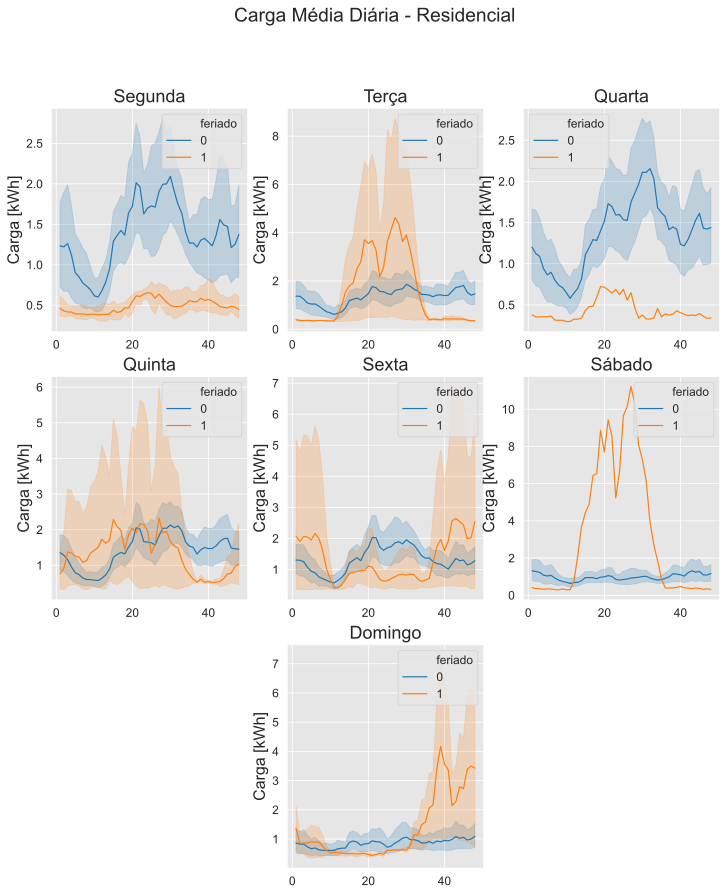

In [66]:
fig, axs = plt.subplots(nrows = 3, ncols=3)

sns.lineplot(data = res_mon, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[0,0])
axs[0,0].set_ylabel("Carga [kWh]")
axs[0,0].set_xlabel("")
axs[0,0].set_title('Segunda')

sns.lineplot(data = res_tue, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[0,1])
axs[0,1].set_ylabel("Carga [kWh]")
axs[0,1].set_xlabel("")
axs[0,1].set_title('Terça')

sns.lineplot(data = res_wed, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[0,2])
axs[0,2].set_ylabel("Carga [kWh]")
axs[0,2].set_xlabel("")
axs[0,2].set_title('Quarta')

sns.lineplot(data = res_thu, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[1,0])
axs[1,0].set_ylabel("Carga [kWh]")
axs[1,0].set_xlabel("")
axs[1,0].set_title('Quinta')

sns.lineplot(data = res_fri, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[1,1])
axs[1,1].set_ylabel("Carga [kWh]")
axs[1,1].set_xlabel("")
axs[1,1].set_title('Sexta')

sns.lineplot(data = res_sat, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[1,2])
axs[1,2].set_ylabel("Carga [kWh]")
axs[1,2].set_xlabel("")
axs[1,2].set_title('Sábado')

sns.lineplot(data = res_sun, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[2,1])
axs[2,1].set_ylabel("Carga [kWh]")
axs[2,1].set_xlabel("")
axs[2,1].set_title('Domingo')

axs[2,0].axis('off')
axs[2,2].axis('off')

fig.suptitle('Carga Média Diária - Residencial')
plt.savefig('C:/Users/vitmi/Desktop/TCC/Imagens/Consumo_Diario_res.png')
fig.tight_layout
plt.show()

In [27]:
ind_mon, ind_tue, ind_wed, ind_thu, ind_fri, ind_sat, ind_sun = week_year(data_ind, 'week_day')

<bound method Figure.tight_layout of <Figure size 720x576 with 9 Axes>>

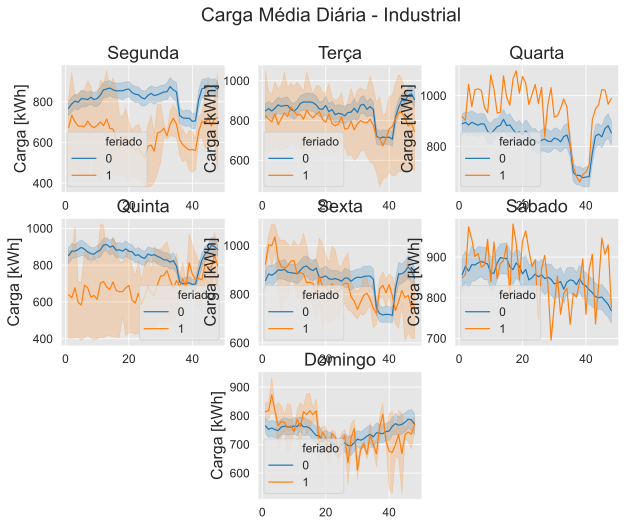

In [28]:
fig, axs = plt.subplots(nrows = 3, ncols=3)

sns.lineplot(data = ind_mon, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[0,0])
axs[0,0].set_ylabel("Carga [kWh]")
axs[0,0].set_xlabel("")
axs[0,0].set_title('Segunda')

sns.lineplot(data = ind_tue, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[0,1])
axs[0,1].set_ylabel("Carga [kWh]")
axs[0,1].set_xlabel("")
axs[0,1].set_title('Terça')

sns.lineplot(data = ind_wed, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[0,2])
axs[0,2].set_ylabel("Carga [kWh]")
axs[0,2].set_xlabel("")
axs[0,2].set_title('Quarta')

sns.lineplot(data = ind_thu, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[1,0])
axs[1,0].set_ylabel("Carga [kWh]")
axs[1,0].set_xlabel("")
axs[1,0].set_title('Quinta')

sns.lineplot(data = ind_fri, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[1,1])
axs[1,1].set_ylabel("Carga [kWh]")
axs[1,1].set_xlabel("")
axs[1,1].set_title('Sexta')

sns.lineplot(data = ind_sat, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[1,2])
axs[1,2].set_ylabel("Carga [kWh]")
axs[1,2].set_xlabel("")
axs[1,2].set_title('Sábado')

sns.lineplot(data = ind_sun, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[2,1])
axs[2,1].set_ylabel("Carga [kWh]")
axs[2,1].set_xlabel("")
axs[2,1].set_title('Domingo')

axs[2,0].axis('off')
axs[2,2].axis('off')

fig.suptitle('Carga Média Diária - Industrial')
plt.savefig('C:/Users/vitmi/Desktop/TCC/Imagens/Consumo_Diario_ind.png')
fig.tight_layout

In [67]:
com_mon, com_tue, com_wed, com_thu, com_fri, com_sat, com_sun = week_year(data_com, 'week_day')

<bound method Figure.tight_layout of <Figure size 864x1008 with 9 Axes>>

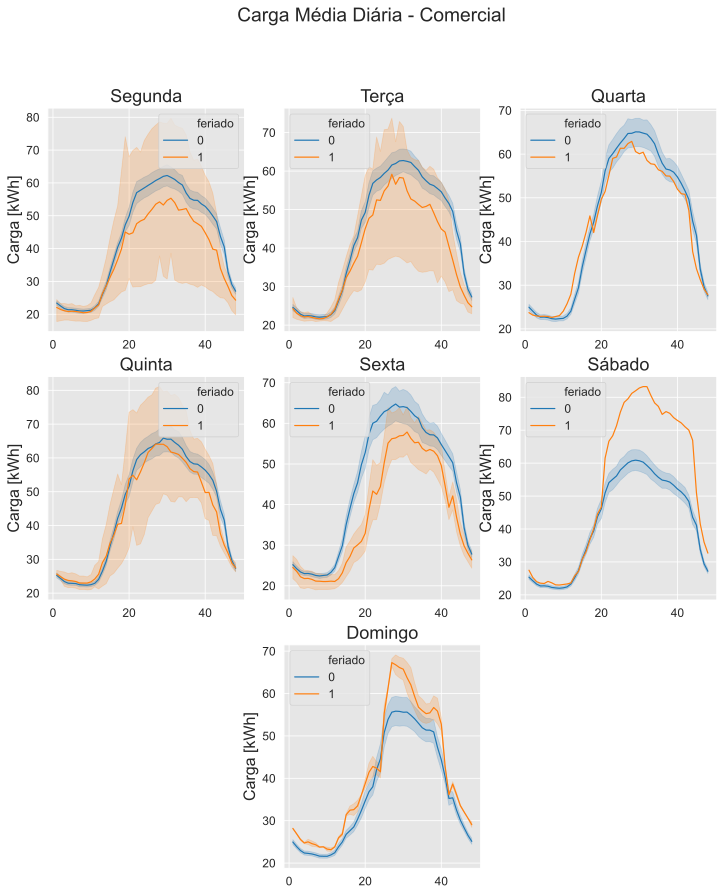

In [69]:
fig, axs = plt.subplots(nrows = 3, ncols=3)

sns.lineplot(data = com_mon, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[0,0])
axs[0,0].set_ylabel("Carga [kWh]")
axs[0,0].set_xlabel("")
axs[0,0].set_title('Segunda')

sns.lineplot(data = com_tue, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[0,1])
axs[0,1].set_ylabel("Carga [kWh]")
axs[0,1].set_xlabel("")
axs[0,1].set_title('Terça')

sns.lineplot(data = com_wed, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[0,2])
axs[0,2].set_ylabel("Carga [kWh]")
axs[0,2].set_xlabel("")
axs[0,2].set_title('Quarta')

sns.lineplot(data = com_thu, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[1,0])
axs[1,0].set_ylabel("Carga [kWh]")
axs[1,0].set_xlabel("")
axs[1,0].set_title('Quinta')

sns.lineplot(data = com_fri, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[1,1])
axs[1,1].set_ylabel("")
axs[1,1].set_xlabel("")
axs[1,1].set_title('Sexta')

sns.lineplot(data = com_sat, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[1,2])
axs[1,2].set_ylabel("Carga [kWh]")
axs[1,2].set_xlabel("")
axs[1,2].set_title('Sábado')

sns.lineplot(data = com_sun, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[2,1])
axs[2,1].set_ylabel("Carga [kWh]")
axs[2,1].set_xlabel("")
axs[2,1].set_title('Domingo')

axs[2,0].axis('off')
axs[2,2].axis('off')

fig.suptitle('Carga Média Diária - Comercial')
plt.savefig('C:/Users/vitmi/Desktop/TCC/Imagens/Consumo_Diario_com.png')
fig.tight_layout

In [70]:
ppm_mon, ppm_tue, ppm_wed, ppm_thu, ppm_fri, ppm_sat, ppm_sun = week_year(data_ppm, 'week_day')

<bound method Figure.tight_layout of <Figure size 864x1008 with 9 Axes>>

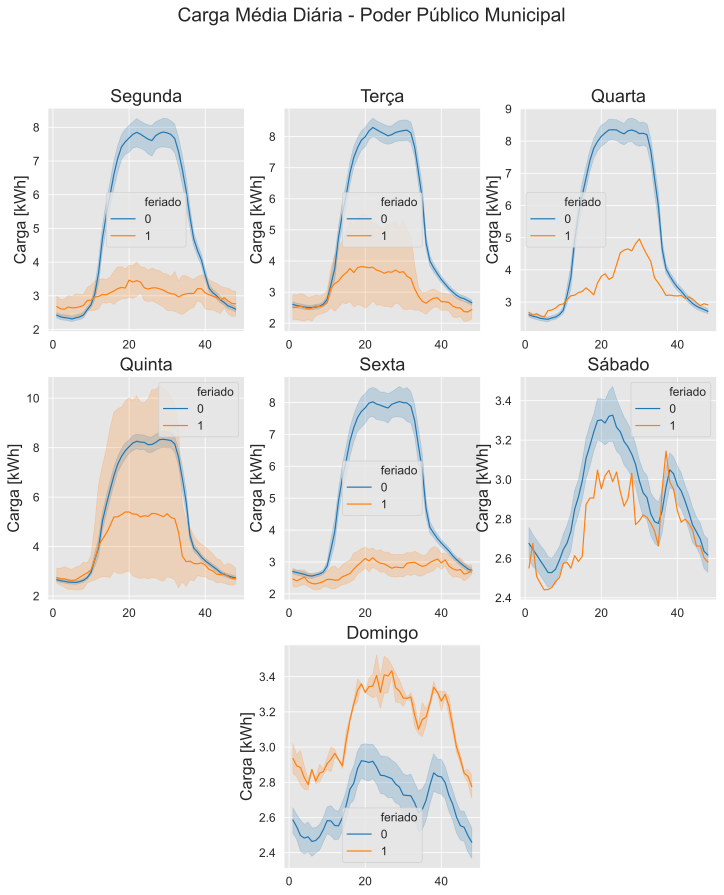

In [71]:
fig, axs = plt.subplots(nrows = 3, ncols=3)

sns.lineplot(data = ppm_mon, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[0,0])
axs[0,0].set_ylabel("Carga [kWh]")
axs[0,0].set_xlabel("")
axs[0,0].set_title('Segunda')

sns.lineplot(data = ppm_tue, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[0,1])
axs[0,1].set_ylabel("Carga [kWh]")
axs[0,1].set_xlabel("")
axs[0,1].set_title('Terça')

sns.lineplot(data = ppm_wed, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[0,2])
axs[0,2].set_ylabel("Carga [kWh]")
axs[0,2].set_xlabel("")
axs[0,2].set_title('Quarta')

sns.lineplot(data = ppm_thu, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[1,0])
axs[1,0].set_ylabel("Carga [kWh]")
axs[1,0].set_xlabel("")
axs[1,0].set_title('Quinta')

sns.lineplot(data = ppm_fri, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[1,1])
axs[1,1].set_ylabel("Carga [kWh]")
axs[1,1].set_xlabel("")
axs[1,1].set_title('Sexta')

sns.lineplot(data = ppm_sat, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[1,2])
axs[1,2].set_ylabel("Carga [kWh]")
axs[1,2].set_xlabel("")
axs[1,2].set_title('Sábado')

sns.lineplot(data = ppm_sun, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[2,1])
axs[2,1].set_ylabel("Carga [kWh]")
axs[2,1].set_xlabel("")
axs[2,1].set_title('Domingo')

axs[2,0].axis('off')
axs[2,2].axis('off')

fig.suptitle('Carga Média Diária - Poder Público Municipal')
plt.savefig('C:/Users/vitmi/Desktop/TCC/Imagens/Consumo_Diario_ppm.png')
fig.tight_layout

In [72]:
sp_mon, sp_tue, sp_wed, sp_thu, sp_fri, sp_sat, sp_sun = week_year(data_sp, 'week_day')

<bound method Figure.tight_layout of <Figure size 864x1008 with 9 Axes>>

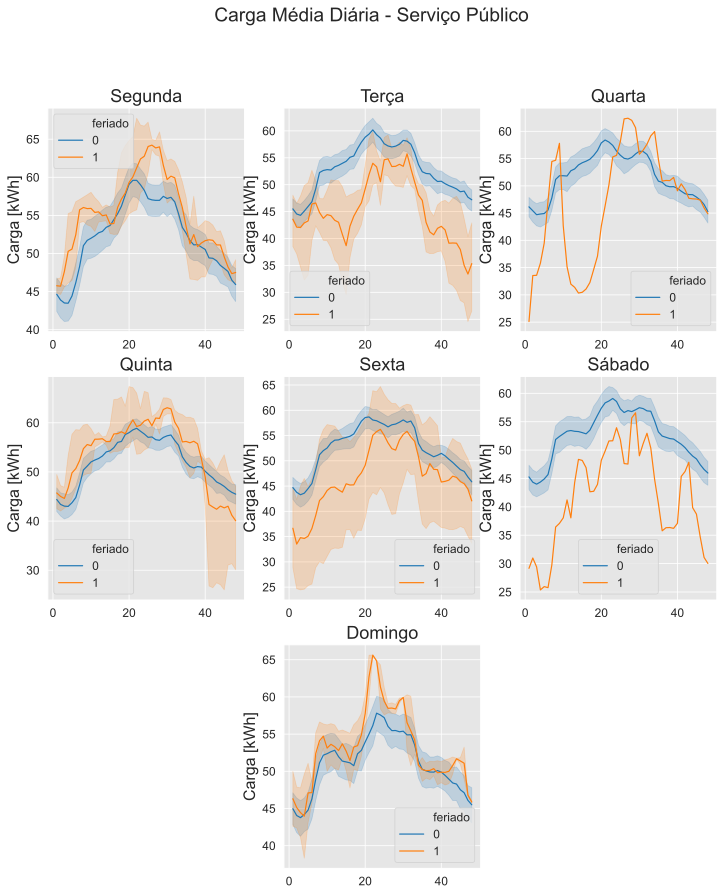

In [73]:
fig, axs = plt.subplots(nrows = 3, ncols=3)

sns.lineplot(data = sp_mon, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[0,0])
axs[0,0].set_ylabel("Carga [kWh]")
axs[0,0].set_xlabel("")
axs[0,0].set_title('Segunda')

sns.lineplot(data = sp_tue, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[0,1])
axs[0,1].set_ylabel("Carga [kWh]")
axs[0,1].set_xlabel("")
axs[0,1].set_title('Terça')

sns.lineplot(data = sp_wed, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[0,2])
axs[0,2].set_ylabel("Carga [kWh]")
axs[0,2].set_xlabel("")
axs[0,2].set_title('Quarta')

sns.lineplot(data = sp_thu, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[1,0])
axs[1,0].set_ylabel("Carga [kWh]")
axs[1,0].set_xlabel("")
axs[1,0].set_title('Quinta')

sns.lineplot(data = sp_fri, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[1,1])
axs[1,1].set_ylabel("Carga [kWh]")
axs[1,1].set_xlabel("")
axs[1,1].set_title('Sexta')

sns.lineplot(data = sp_sat, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[1,2])
axs[1,2].set_ylabel("Carga [kWh]")
axs[1,2].set_xlabel("")
axs[1,2].set_title('Sábado')

sns.lineplot(data = sp_sun, x='new', y="valor_kwh", hue = 'feriado' ,ax=axs[2,1])
axs[2,1].set_ylabel("Carga [kWh]")
axs[2,1].set_xlabel("")
axs[2,1].set_title('Domingo')

axs[2,0].axis('off')
axs[2,2].axis('off')

fig.suptitle('Carga Média Diária - Serviço Público')
plt.savefig('C:/Users/vitmi/Desktop/TCC/Imagens/Consumo_Diario_sp.png')
fig.tight_layout

## Estudo 5 - Periodicidade e freqüência das cargas

In [35]:
def fft(df1, df2):
    vkwh_2018 = np.asarray(df1.valor_kwh.dropna())
    vkwh_2019 = np.asarray(df2.valor_kwh.dropna())

    NFFT=1024 #NFFT-point DFT      

    X_2018 = rfft(vkwh_2018,NFFT) #compute DFT using FFT  
    X_2018 = X_2018[1:]

    X_2019 = rfft(vkwh_2019, NFFT) #compute DFT using FFT  
    X_2019 = X_2019[1:]

    fVals= np.arange(start = 0, stop = NFFT/2)/NFFT #DFT Sample points

    return X_2018, X_2019, fVals

In [36]:
res_5_2018, res_5_2019, x1 = fft(res_tot_2018, res_tot_2019)

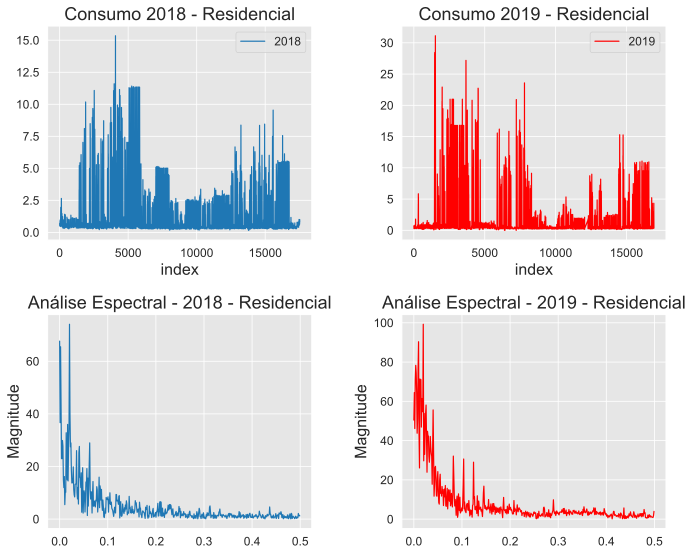

In [37]:
fig, axs = plt.subplots(nrows = 2, ncols=2)

sns.lineplot(data = res_tot_2018, x="index", y="valor_kwh", ax=axs[0,0], label = '2018' )
axs[0,0].set_ylabel("")
axs[0,0].set_title('Consumo 2018 - Residencial')

sns.lineplot(data = res_tot_2019, x="index", y="valor_kwh", ax=axs[0,1], label = '2019', color = 'red' )
axs[0,1].set_ylabel("")
axs[0,1].set_title('Consumo 2019 - Residencial')

axs[1,0].plot(x1, np.abs(res_5_2018))
axs[1,0].set_title('Análise Espectral - 2018 - Residencial')
axs[1,0].set_xlabel('')
axs[1,0].set_ylabel('Magnitude');

axs[1,1].plot(x1, np.abs(res_5_2019), color = 'red')
axs[1,1].set_ylabel("Magnitude")
axs[1,1].set_title('Análise Espectral - 2019 - Residencial')

fig.tight_layout()
fig.show()

In [38]:
ind_5_2018, ind_5_2019, x2 = fft(ind_tot_2018, ind_tot_2019)

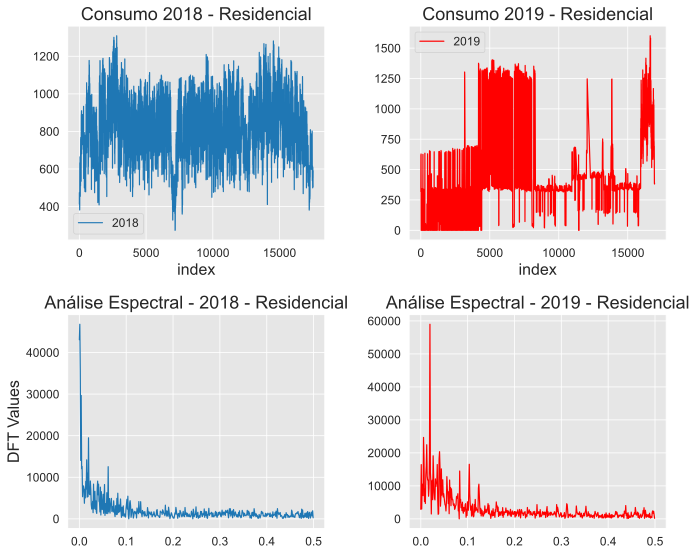

In [39]:
fig, axs = plt.subplots(nrows = 2, ncols=2)

sns.lineplot(data = ind_tot_2018, x="index", y="valor_kwh", ax=axs[0,0], label = '2018' )
axs[0,0].set_ylabel("")
axs[0,0].set_title('Consumo 2018 - Residencial')

sns.lineplot(data = ind_tot_2019, x="index", y="valor_kwh", ax=axs[0,1], label = '2019', color = 'red' )
axs[0,1].set_ylabel("")
axs[0,1].set_title('Consumo 2019 - Residencial')

axs[1,0].plot(x2, np.abs(ind_5_2018))
axs[1,0].set_title('Análise Espectral - 2018 - Residencial')
axs[1,0].set_xlabel('')
axs[1,0].set_ylabel('DFT Values');

axs[1,1].plot(x2, np.abs(ind_5_2019), color = 'red')
axs[1,1].set_ylabel("")
axs[1,1].set_title('Análise Espectral - 2019 - Residencial')

fig.tight_layout()
fig.show()

In [40]:
com_5_2018, com_5_2019, x3 = fft(com_tot_2018, com_tot_2019)

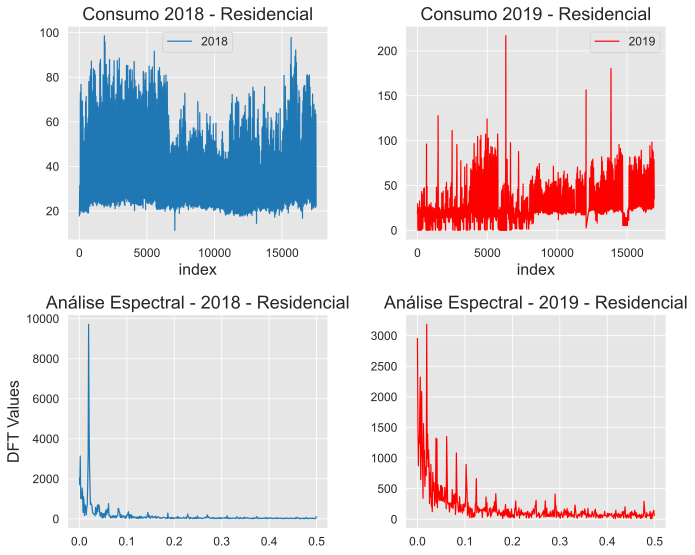

In [41]:
fig, axs = plt.subplots(nrows = 2, ncols=2)

sns.lineplot(data = com_tot_2018, x="index", y="valor_kwh", ax=axs[0,0], label = '2018' )
axs[0,0].set_ylabel("")
axs[0,0].set_title('Consumo 2018 - Residencial')

sns.lineplot(data = com_tot_2019, x="index", y="valor_kwh", ax=axs[0,1], label = '2019', color = 'red' )
axs[0,1].set_ylabel("")
axs[0,1].set_title('Consumo 2019 - Residencial')

axs[1,0].plot(x3, np.abs(com_5_2018))
axs[1,0].set_title('Análise Espectral - 2018 - Residencial')
axs[1,0].set_xlabel('')
axs[1,0].set_ylabel('DFT Values');

axs[1,1].plot(x3, np.abs(com_5_2019), color = 'red')
axs[1,1].set_ylabel("")
axs[1,1].set_title('Análise Espectral - 2019 - Residencial')

fig.tight_layout()
fig.show()

In [42]:
ppm_5_2018, ppm_5_2019, x4 = fft(ppm_tot_2018, ppm_tot_2019)

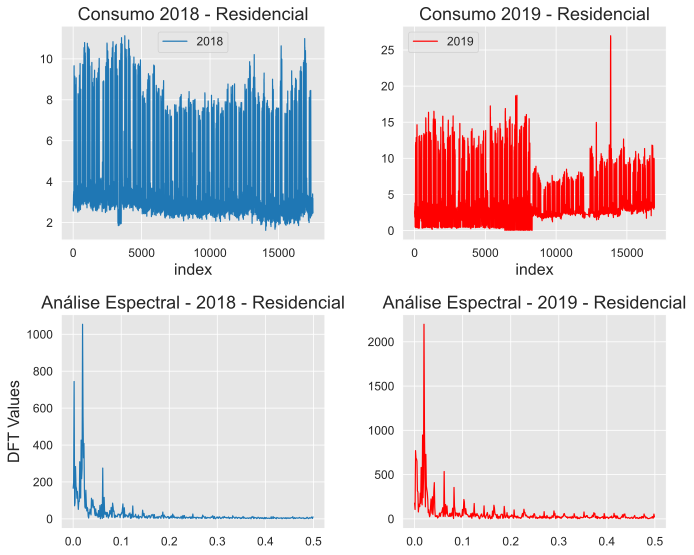

In [43]:

fig, axs = plt.subplots(nrows = 2, ncols=2)

sns.lineplot(data = ppm_tot_2018, x="index", y="valor_kwh", ax=axs[0,0], label = '2018' )
axs[0,0].set_ylabel("")
axs[0,0].set_title('Consumo 2018 - Residencial')

sns.lineplot(data = ppm_tot_2019, x="index", y="valor_kwh", ax=axs[0,1], label = '2019', color = 'red' )
axs[0,1].set_ylabel("")
axs[0,1].set_title('Consumo 2019 - Residencial')

axs[1,0].plot(x4, np.abs(ppm_5_2018))
axs[1,0].set_title('Análise Espectral - 2018 - Residencial')
axs[1,0].set_xlabel('')
axs[1,0].set_ylabel('DFT Values');

axs[1,1].plot(x4, np.abs(ppm_5_2019), color = 'red')
axs[1,1].set_ylabel("")
axs[1,1].set_title('Análise Espectral - 2019 - Residencial')

fig.tight_layout()
fig.show()

In [44]:
sp_5_2018, sp_5_2019, x5 = fft(sp_tot_2018, sp_tot_2019)

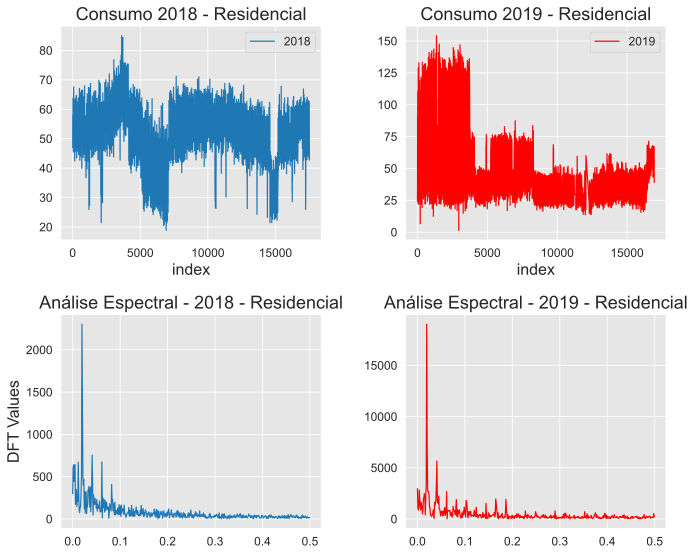

In [45]:
fig, axs = plt.subplots(nrows = 2, ncols=2)

sns.lineplot(data = sp_tot_2018, x="index", y="valor_kwh", ax=axs[0,0], label = '2018' )
axs[0,0].set_ylabel("")
axs[0,0].set_title('Consumo 2018 - Residencial')

sns.lineplot(data = sp_tot_2019, x="index", y="valor_kwh", ax=axs[0,1], label = '2019', color = 'red' )
axs[0,1].set_ylabel("")
axs[0,1].set_title('Consumo 2019 - Residencial')

axs[1,0].plot(x5, np.abs(sp_5_2018))
axs[1,0].set_title('Análise Espectral - 2018 - Residencial')
axs[1,0].set_xlabel('')
axs[1,0].set_ylabel('DFT Values');

axs[1,1].plot(x5, np.abs(sp_5_2019), color = 'red')
axs[1,1].set_ylabel("")
axs[1,1].set_title('Análise Espectral - 2019 - Residencial')

fig.tight_layout()
fig.show()

## Estudo 6 - Influência de cargas passadas sobre a carga

In [28]:
def loadinfo(df, column1, column2, colum):
    
    # Input: df receives dataframe and column receives string
    
    df = df[(df['year']) == 2018]
    
    # Mean Value
    mean_val = df.groupby(df[column1])[column2].mean()
    mean_val = pd.DataFrame(mean_val)
    mean_val.columns = ['valor_kwh_medio']
    
    # Max Value
    max_val  = df.groupby(df[column1])[column2].max()
    max_val  = pd.DataFrame(max_val)
    max_val.columns = ['valor_kwh_max']
    
    # Min Value
    min_val  = df.groupby(df[column1])[column2].min()
    min_val  = pd.DataFrame(min_val)
    min_val.columns = ['valor_kwh_min']
    
    result = pd.concat([mean_val, max_val, min_val], axis=1).reindex(mean_val.index)
    
    return result

In [29]:
def get_stats(df):
    
    df.index = pd.to_datetime(df.index)
    shift_df = df.shift(periods=1, fill_value=0)
    shift_df.columns = ['valor_kwh_medio_1', 'valor_kwh_max_1', 'valor_kwh_min_1']

    result = pd.concat([df, shift_df], axis=1).reindex(df.index)
    
    return result

In [30]:
%%time

data_res_stats = loadinfo(data_res, 'data_med', 'valor_kwh', 'year')
data_ind_stats = loadinfo(data_ind, 'data_med', 'valor_kwh', 'year')
data_com_stats = loadinfo(data_com, 'data_med', 'valor_kwh', 'year')
data_ppm_stats = loadinfo(data_ppm, 'data_med', 'valor_kwh', 'year')
data_sp_stats   = loadinfo(data_sp, 'data_med', 'valor_kwh', 'year') 

Wall time: 186 ms


In [31]:
data_res_stats_all = get_stats(data_res_stats)
data_com_stats_all = get_stats(data_com_stats)
data_ind_stats_all = get_stats(data_ind_stats)
data_ppm_stats_all = get_stats(data_ppm_stats)
data_sp_stats_all = get_stats(data_sp_stats)

<bound method Figure.tight_layout of <Figure size 864x1152 with 3 Axes>>

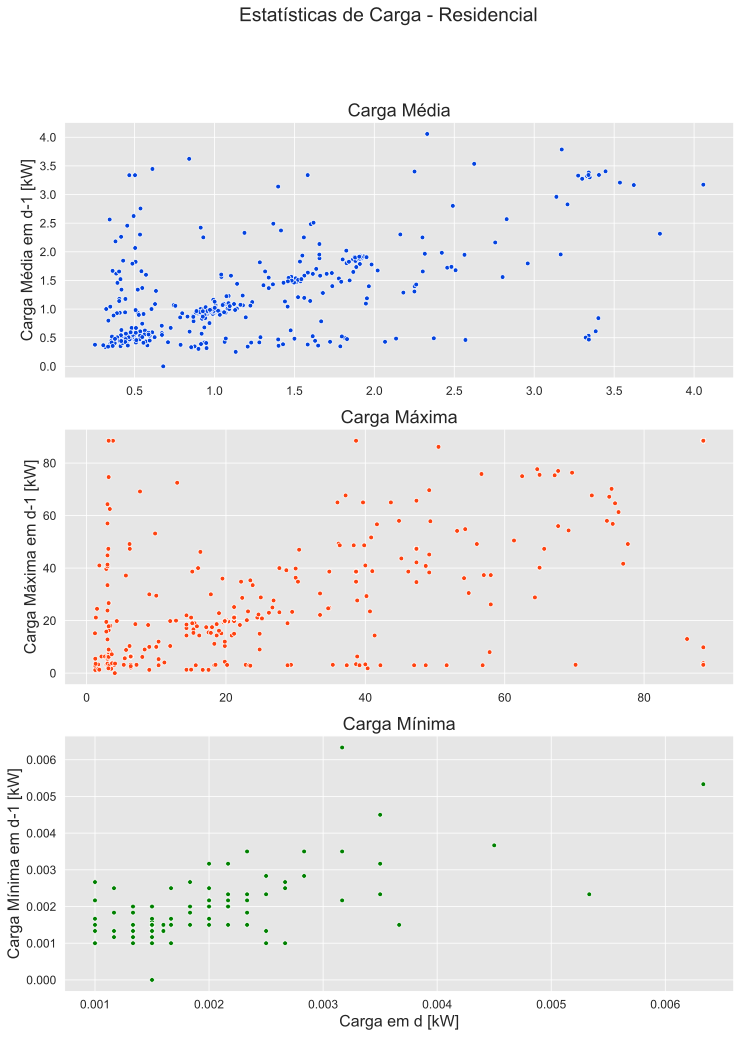

In [34]:
fig, axs = plt.subplots(nrows = 3, ncols=1)

sns.scatterplot(data = data_res_stats_all, x="valor_kwh_medio", y="valor_kwh_medio_1", ax=axs[0], color = 'xkcd:blue')
axs[0].set_ylabel("Carga Média em d-1 [kW]")
axs[0].set_xlabel("")
axs[0].set_title('Carga Média')

sns.scatterplot(data = data_res_stats_all, x="valor_kwh_max", y="valor_kwh_max_1", ax=axs[1], color = 'xkcd:orangered')
axs[1].set_ylabel("Carga Máxima em d-1 [kW]")
axs[1].set_xlabel("")
axs[1].set_title('Carga Máxima')

sns.scatterplot(data = data_res_stats_all, x="valor_kwh_min", y="valor_kwh_min_1", ax=axs[2], color = 'green')
axs[2].set_ylabel("Carga Mínima em d-1 [kW]")
axs[2].set_xlabel("Carga em d [kW]")
axs[2].set_title('Carga Mínima')

fig.suptitle('Estatísticas de Carga - Residencial')
plt.savefig('C:/Users/vitmi/Desktop/TCC/Imagens/res_stats.png')
fig.tight_layout

<bound method Figure.tight_layout of <Figure size 864x1152 with 3 Axes>>

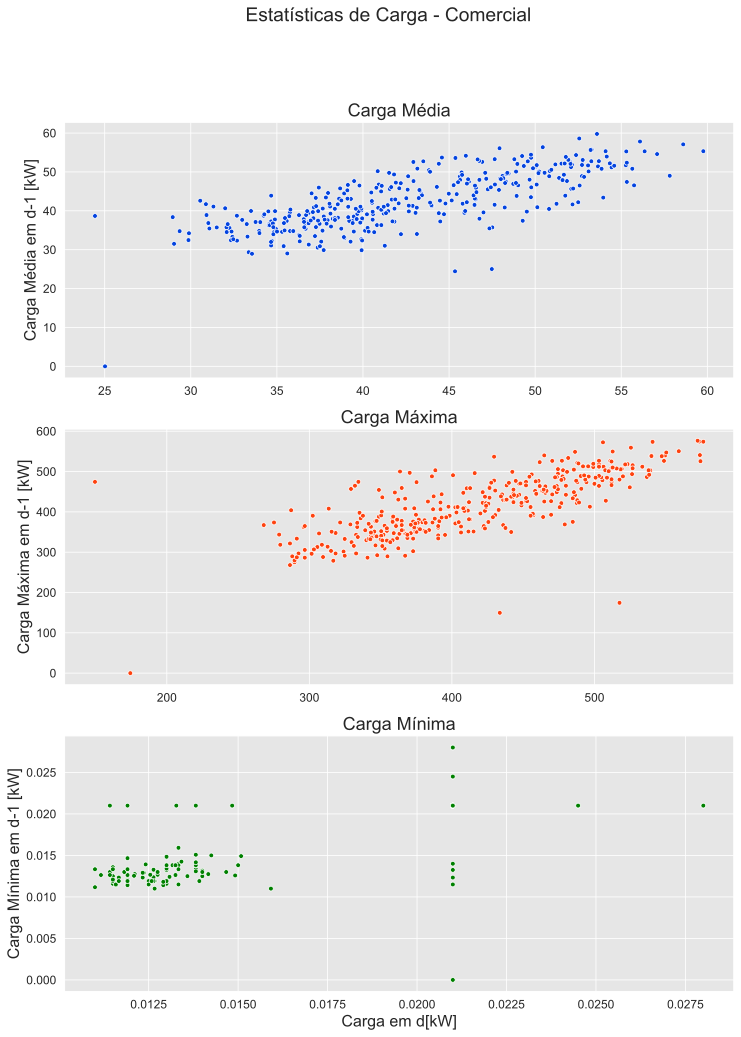

In [35]:
fig, axs = plt.subplots(nrows = 3, ncols=1)

sns.scatterplot(data = data_com_stats_all, x="valor_kwh_medio", y="valor_kwh_medio_1", ax=axs[0], color = 'xkcd:blue')
axs[0].set_ylabel("Carga Média em d-1 [kW]")
axs[0].set_xlabel("")
axs[0].set_title('Carga Média')

sns.scatterplot(data = data_com_stats_all, x="valor_kwh_max", y="valor_kwh_max_1", ax=axs[1], color = 'xkcd:orangered')
axs[1].set_ylabel("Carga Máxima em d-1 [kW]")
axs[1].set_xlabel("")
axs[1].set_title('Carga Máxima')

sns.scatterplot(data = data_com_stats_all, x="valor_kwh_min", y="valor_kwh_min_1", ax=axs[2], color = 'green')
axs[2].set_ylabel("Carga Mínima em d-1 [kW]")
axs[2].set_xlabel("Carga em d[kW]")
axs[2].set_title('Carga Mínima')

fig.suptitle('Estatísticas de Carga - Comercial')
plt.savefig('C:/Users/vitmi/Desktop/TCC/Imagens/com_stats.png')
fig.tight_layout

<bound method Figure.tight_layout of <Figure size 864x1152 with 3 Axes>>

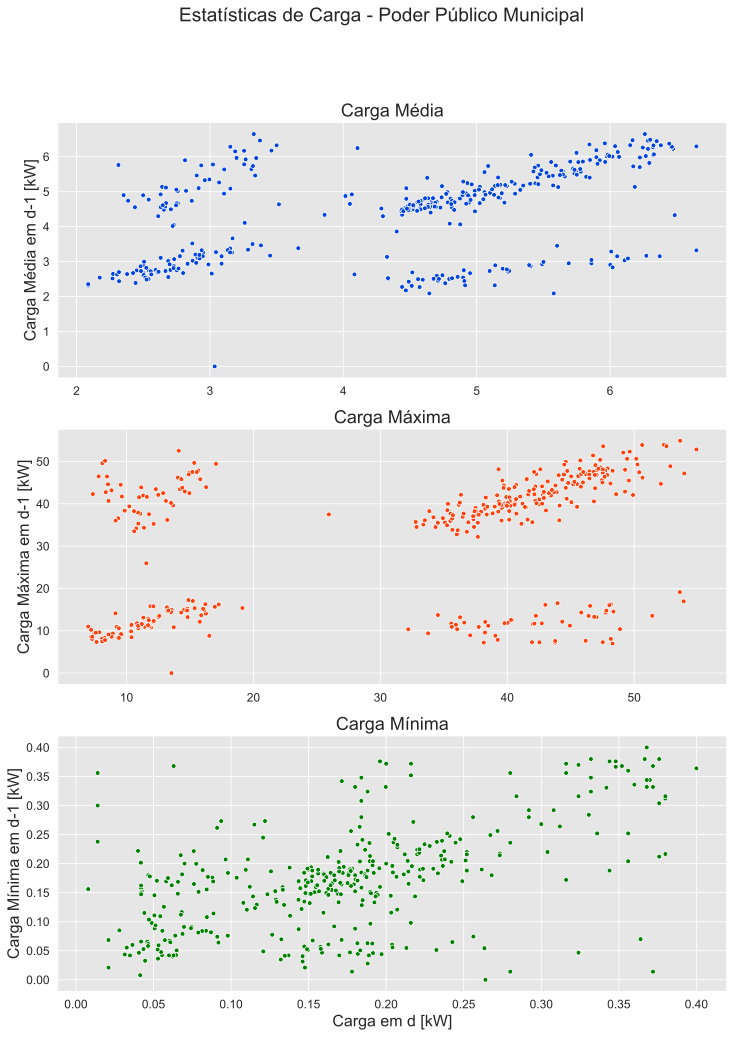

In [36]:
fig, axs = plt.subplots(nrows = 3, ncols=1)

sns.scatterplot(data = data_ppm_stats_all, x="valor_kwh_medio", y="valor_kwh_medio_1", ax=axs[0], color = 'xkcd:blue')
axs[0].set_ylabel("Carga Média em d-1 [kW]")
axs[0].set_xlabel("")
axs[0].set_title('Carga Média')

sns.scatterplot(data = data_ppm_stats_all, x="valor_kwh_max", y="valor_kwh_max_1", ax=axs[1], color = 'xkcd:orangered')
axs[1].set_ylabel("Carga Máxima em d-1 [kW]")
axs[1].set_xlabel("")
axs[1].set_title('Carga Máxima')

sns.scatterplot(data = data_ppm_stats_all, x="valor_kwh_min", y="valor_kwh_min_1", ax=axs[2], color = 'green')
axs[2].set_ylabel("Carga Mínima em d-1 [kW]")
axs[2].set_xlabel("Carga em d [kW]")
axs[2].set_title('Carga Mínima')

fig.suptitle('Estatísticas de Carga - Poder Público Municipal')
plt.savefig('C:/Users/vitmi/Desktop/TCC/Imagens/ppm_stats.png')
fig.tight_layout

<bound method Figure.tight_layout of <Figure size 864x1152 with 3 Axes>>

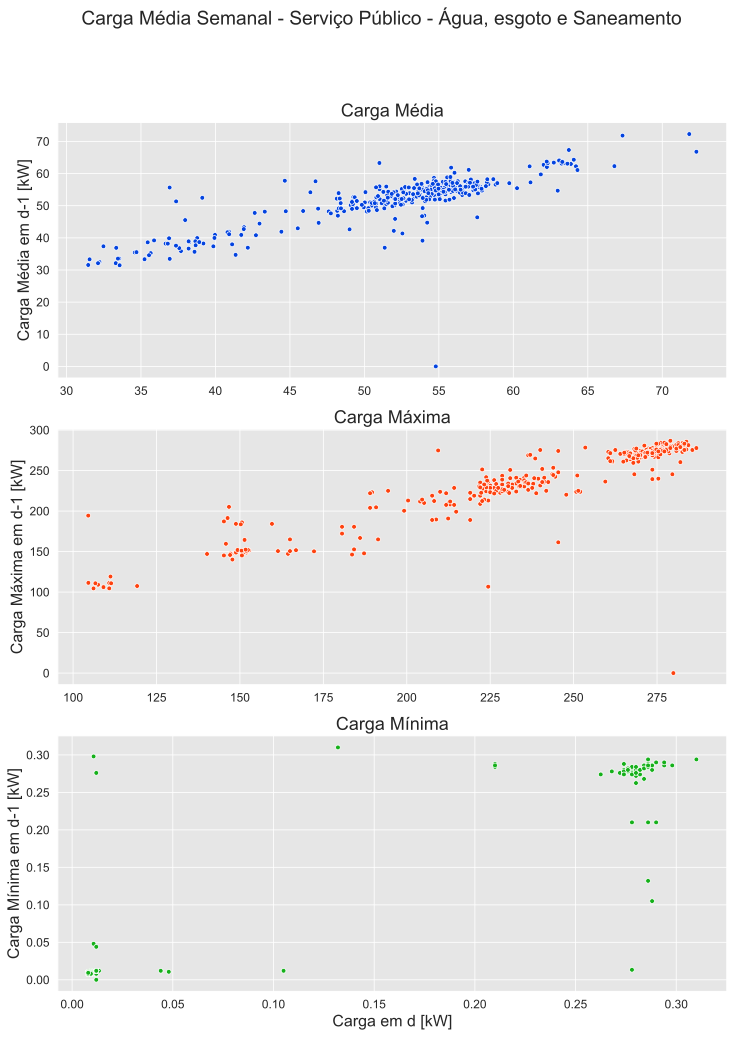

In [37]:
fig, axs = plt.subplots(nrows = 3, ncols=1)

sns.scatterplot(data = data_sp_stats_all, x="valor_kwh_medio", y="valor_kwh_medio_1", ax=axs[0], color = 'xkcd:blue')
axs[0].set_ylabel("Carga Média em d-1 [kW]")
axs[0].set_xlabel("")
axs[0].set_title('Carga Média')

sns.scatterplot(data = data_sp_stats_all, x="valor_kwh_max", y="valor_kwh_max_1", ax=axs[1], color = 'xkcd:orangered')
axs[1].set_ylabel("Carga Máxima em d-1 [kW]")
axs[1].set_xlabel("")
axs[1].set_title('Carga Máxima')

sns.scatterplot(data = data_sp_stats_all, x="valor_kwh_min", y="valor_kwh_min_1", ax=axs[2], color = 'xkcd:green')
axs[2].set_ylabel("Carga Mínima em d-1 [kW]")
axs[2].set_xlabel("Carga em d [kW]")
axs[2].set_title('Carga Mínima')

fig.suptitle('Carga Média Semanal - Serviço Público - Água, esgoto e Saneamento')
plt.savefig('C:/Users/vitmi/Desktop/TCC/Imagens/sp_stats.png')
fig.tight_layout